# Image Classification

In this practical part of the assignment, you will develop a classification algorithm that predicts whether an image contains a cat or a dog. You wil do this using the `pytorch` deep learning framework.

In [ ]:
# Download the data 
!pip install catsndogs camels

In [ ]:
from catsndogs.training import cats, dogs # The lists of cat and dog images.

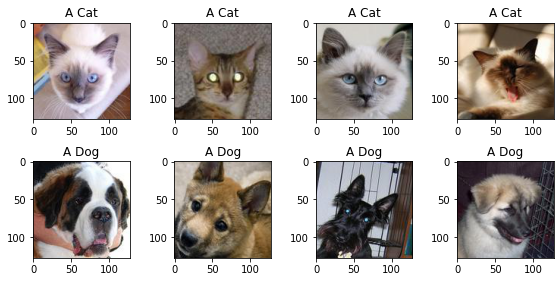

In [ ]:
# A few examples of the images in the dataset.
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
 
f, axs = plt.subplots(2, 4, figsize = (8, 4))
for i in range(4):
    img = np.random.choice(cats)
    ax = axs[0, i]
    ax.set_title("A Cat")
    ax.imshow(Image.open(img))
for i in range(4):
    img = np.random.choice(dogs)
    ax = axs[1, i]
    ax.set_title("A Dog")
    ax.imshow(Image.open(img))
plt.tight_layout()

In [ ]:
# Import pytorch framework
import torch
help(torch.tensor)

Help on built-in function tensor:

tensor(...)
    tensor(data, *, dtype=None, device=None, requires_grad=False, pin_memory=False) -> Tensor
    
    Constructs a tensor with :attr:`data`.
    
    .. warning::
    
        :func:`torch.tensor` always copies :attr:`data`. If you have a Tensor
        ``data`` and want to avoid a copy, use :func:`torch.Tensor.requires_grad_`
        or :func:`torch.Tensor.detach`.
        If you have a NumPy ``ndarray`` and want to avoid a copy, use
        :func:`torch.as_tensor`.
    
    .. warning::
    
        When data is a tensor `x`, :func:`torch.tensor` reads out 'the data' from whatever it is passed,
        and constructs a leaf variable. Therefore ``torch.tensor(x)`` is equivalent to ``x.clone().detach()``
        and ``torch.tensor(x, requires_grad=True)`` is equivalent to ``x.clone().detach().requires_grad_(True)``.
        The equivalents using ``clone()`` and ``detach()`` are recommended.
    
    Args:
        data (array_like): Initia

In [ ]:
# GPU acceleration
# First check if CUDA is available.
print(torch.cuda.is_available())
cuda = torch.device("cuda")
cpu = torch.device("cpu")

True


In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda') # Default CUDA device
else:
    device = torch.device('cpu')

In [ ]:
# Load the images into tensors and normalize the image values 
from torchvision.transforms.functional import to_tensor, to_pil_image
from catsndogs.training import folder
from torchvision.datasets import ImageFolder
import torch
from torchvision.transforms import Compose, ToTensor, Normalize

transform = Compose([ToTensor(),
                     Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
images = ImageFolder(folder, transform=transform)
image, label = images[0]
print("Type of image is now:", type(image))

Type of image is now: <class 'torch.Tensor'>


In [ ]:
# This function inverts the transformation of the input images.
def to_image(tensor):
    tensor = 0.5 * (tensor + 1.0)
    return to_pil_image(tensor)

In [ ]:
# Split the data into training and validation set
n_train = int(0.9 * len(images))
n_val = len(images) - n_train
training_data_catsndogs, validation_data_catsndogs = torch.utils.data.random_split(images, (n_train, n_val))

In [ ]:
# Batch and shuffle existing data
rom torch.utils.data import DataLoader
training_loader_catsndogs = DataLoader(training_data_catsndogs, batch_size=32, shuffle=True)
validation_loader_catsndogs = DataLoader(validation_data_catsndogs, batch_size=32, shuffle=True)

In [ ]:
# Build a convolutional neural network
class ConvMaxPool(nn.Module):
    """
    Usually, this docstring should contain useful information about this
    class but this would make the exercise too easy.
    """
    def __init__(self):
        """
        Create a new mysterious network.
        """
        super().__init__()
        self.conv_1 = nn.Conv2d(3, 32, 5, stride=1)
        self.mp_1 = nn.MaxPool2d(4, stride=4)
        self.conv_2 = nn.Conv2d(32, 64, 5, stride=1)
        self.mp_2 = nn.MaxPool2d(2, stride=2)
        self.conv_3 = nn.Conv2d(64, 128, 3, stride=1)
        self.mp_3 = nn.MaxPool2d(2, stride=2)
        self.fc_1 = nn.Linear(3200, 512)
        self.fc_2 = nn.Linear(512, 1)
        
    def forward(self, x):
        """
        The forward method required by nn.Module base class.
        """
        x = self.conv_1(x)
        x = torch.relu(x)
        x = self.mp_1(x)
        x = self.conv_2(x)
        x = torch.relu(x)
        x = self.mp_2(x)
        x = self.conv_3(x)
        x = torch.relu(x)
        x = self.mp_3(x)
        x = x.flatten(1, -1)
        x = self.fc_1(x)
        x = torch.relu(x)
        x = self.fc_2(x)

        return x
    

In [ ]:
# The training loop
def train_epoch(training_loader,
                validation_loader,
                model,
                loss,
                optimizer,
                device):
    
    model.train()
    model.to(device)
    
    training_loss = 0.0
    n = len(training_loader)
    
    for i, (x, y) in enumerate(training_loader):
        
        # Set gradients to zero.
        optimizer.zero_grad()
        
        # Move input to device
        x = x.to(device)
        y = y.to(device)
        # Predict output, compute loss, perform optimizer step.
        y_pred = model(x)
        l = loss(y_pred, y.view(-1, 1).float())
        l.backward()
        optimizer.step()
        
        training_loss += l.item()
        print("Batch ({} / {}): Loss {:.2f}".format(i, n, l.item()), end="\r")
        
    training_loss /= n
        
    model.eval()
    validation_loss = 0.0
    n = len(validation_loader)
    
    for i, (x, y) in enumerate(validation_loader):
        # Move input to device
        x = x.to(device)
        y = y.to(device)
        
        # Predict output, compute loss, perform optimizer step.
        y_pred = model(x)
        l = loss(y_pred, y.view(-1, 1).float())
        
        validation_loss += l.item()
    validation_loss /= n
    
    model.to(torch.device("cpu"))
    
    return (training_loss, validation_loss)

In [ ]:
class GradientDescent():
 
    def __init__(self,
                 parameters,
                 learning_rate):
        
        self.parameters = list(parameters)
        self.learning_rate = learning_rate
        
    def zero_grad(self):
        for p in self.parameters:
            if not p.grad is None:
                p.grad.zero_()
        
    def step(self):
        for p in self.parameters:

            if p.grad is None:
                continue
            d_p = p.grad

            p.data.add_(d_p, alpha=-self.learning_rate)

In [ ]:
# Choose a suitable loss function
loss = torch.nn.BCEWithLogitsLoss()

current epoch: 1
current epoch: 2
current epoch: 3
current epoch: 4
current epoch: 5
current epoch: 6
current epoch: 7
current epoch: 8
current epoch: 9
current epoch: 10
current epoch: 11
current epoch: 12
current epoch: 13
current epoch: 14
current epoch: 15
current epoch: 16
current epoch: 17
current epoch: 18
current epoch: 19
current epoch: 20


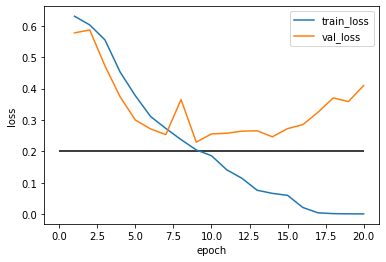

In [ ]:
# Train a convolutional neural network
tls = []
vls = []

cm = ConvMaxPool()

for i in range(1, 21): 
    tl, vl = train_epoch(training_loader_catsndogs, validation_loader_catsndogs, cm, loss, GradientDescent(cm.parameters(), 0.1), device)
    tls.append(tl)
    vls.append(vl)
    print(f"current epoch: {i}")

f, ax = plt.subplots(1, 1)
ax.plot(range(1, 21),
        tls,
        label = "train_loss")
ax.plot(range(1, 21),
        vls,
        label = "val_loss")
ax.legend()
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.hlines(0.2, 0, 20)

In [ ]:
# Tune the network architecture
class TunedConvMaxPool(nn.Module):
  
    def __init__(self):
        """
        Create a new mysterious network.
        """
        super().__init__()
        self.conv_1 = nn.Conv2d(3, 32, 5, stride=1)
        self.mp_1 = nn.MaxPool2d(4, stride=4)
        self.dropout_1 = nn.Dropout(0.5)
        self.conv_2 = nn.Conv2d(32, 64, 5, stride=1)
        self.mp_2 = nn.MaxPool2d(2, stride=2)
        self.dropout_2 = nn.Dropout(0.2)
        self.conv_3 = nn.Conv2d(64, 128, 3, stride=1)
        self.mp_3 = nn.MaxPool2d(2, stride=2)
        # self.dropout_3 = nn.Dropout(0.5)
        self.fc_1 = nn.Linear(3200, 512)
        self.fc_2 = nn.Linear(512, 1)
        
    def forward(self, x):
        """
        The forward method required by nn.Module base class.
        """
        x = self.conv_1(x)
        x = torch.relu(x)
        x = self.mp_1(x)
        x = self.dropout_1(x)
        x = self.conv_2(x)
        x = torch.relu(x)
        x = self.mp_2(x)
        x = self.dropout_1(x)
        x = self.conv_3(x)
        x = torch.relu(x)
        x = self.mp_3(x)
        x = self.dropout_1(x)
        x = x.flatten(1, -1)
        x = self.fc_1(x)
        x = self.dropout_2(x)
        x = torch.relu(x)
        x = self.fc_2(x)

        return x

In [ ]:
# Add a scheduler
class EpochSizeScheduler():
    def __init__(self, optimizer, epoch_size, gamma=0.1):
        self.optimizer = optimizer
        self.epoch_size = epoch_size
        self.gamma = gamma
        self.epoch_count = 0

    def zero_grad(self):
        self.optimizer.zero_grad()
    
    def step(self):
        if self.epoch_count !=0 and self.epoch_count % self.epoch_size == 0:
            self.optimizer.learning_rate = self.optimizer.learning_rate * self.gamma
        self.optimizer.step()


current epoch 79


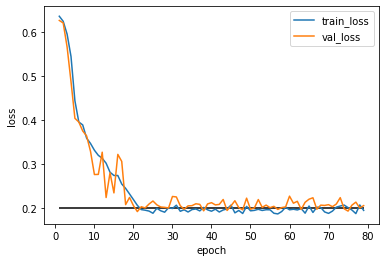

In [ ]:
# Train the network again
from google.colab import output
tls = []
vls = []

tcm = TunedConvMaxPool()
scheduler = EpochSizeScheduler(optimizer=GradientDescent(tcm.parameters(), 0.1), epoch_size=20, gamma=0.1)

good_count = 0

for i in range(1, 80): 
    tl, vl = train_epoch(training_loader_catsndogs, validation_loader_catsndogs, tcm, loss, scheduler, device)
    tls.append(tl)
    vls.append(vl)
    scheduler.epoch_count += 1

    output.clear(output_tags='status_text')
    with output.use_tags('status_text'):
        print(f"current epoch {i}")

    # if vl < 0.2:
    #     good_count += 1
    #     if good_count > 5:
    #         print("Early stop when validation loss < 0.2")
    #         break

f, ax = plt.subplots(1, 1)
ax.plot(range(1, len(tls) + 1),
        tls,
        label = "train_loss")
ax.plot(range(1, len(vls) + 1),
        vls,
        label = "val_loss")
ax.legend()
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.hlines(0.2, 1, len(tls))

In [ ]:
# Computes the true positive and false positive rate
def receiver_operating_characteristic(model,
                                      validation_loader,
                                      ps):
    model.to(device)
    p_count = 0
    n_count = 0
    for x, y in validation_loader:
        p_count += y.sum()
        n_count += len(y) - y.sum()

    fpr = np.zeros(len(ps))
    tpr = np.zeros(len(ps))
    for i, p in enumerate(ps):
        fp, tp = 0, 0
        for x, y in validation_loader:
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            y_pred = torch.sigmoid(y_pred)
            for yi, yi_pred in zip(y, y_pred):
                if yi_pred <= p:
                    continue
                if yi == 1:
                    tp += 1
                else:
                    fp += 1
        
        fpr[i] = fp / n_count
        tpr[i] = tp / p_count

    return (fpr, tpr)

In [ ]:
# Plot the ROC
fpr, tpr = receiver_operating_characteristic(fc, validation_loader_catsndogs, np.linspace(0, 1, 101))

def plot_ROC(fpr,tpr):
    x = np.linspace(0, 1, 101)
    f, ax = plt.subplots(1, 1)
    ax.plot(x, x, c="k", ls="--")
    ax.plot(fpr, tpr)
    ax.set_ylabel("TPR")
    ax.set_xlabel("FPR")
    ax.set_title("Receiver operator characteristic")

In [ ]:
# Calculate the area under the ROC-curve
def auc_roc(fpr, tpr):
    auc_roc = 0
    for i in range(len(np.linspace(0, 1, 101))-1):
        auc_roc += 0.01*(tpr[i]+tpr[i+1])*1/2
    return auc_roc

AUC_ROC of convolutional model:  0.8624400365352628


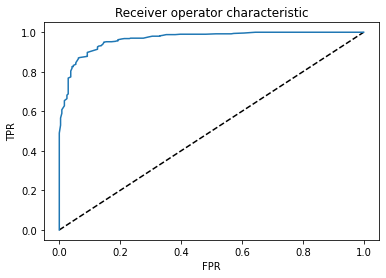

In [ ]:
# Evaluation using ROC and AUC of convolutional model
from catsndogs.test import folder

images = ImageFolder(folder)
transform = Compose([ToTensor(),
                     Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
test_data_catsndogs = ImageFolder(folder, transform=transform)
test_loader_catsndogs=DataLoader(test_data_catsndogs, batch_size=32,shuffle=True)

fpr, tpr = receiver_operating_characteristic(fc, test_loader_catsndogs, np.linspace(0, 1, 101))
fpr_cnn, tpr_cnn = receiver_operating_characteristic(tcm, test_loader_catsndogs, np.linspace(0, 1, 101))
plot_ROC(fpr_cnn,tpr_cnn)
print('AUC_ROC of convolutional model: ',auc_roc(fpr_cnn,tpr_cnn))